<a href="https://colab.research.google.com/github/MrCharli03/RL_BFRRCE/blob/main/notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Esteban Becerra, Carlos Cruzado, Anastasiya Ruzhytska Email: esteban.becerraf@um.es carlos.cruzadoe1@um.es anastasiya.r.r@um.es Date: 2025/02/24

# Estudio de algunos algoritmos básicos

## 1. Métodos Tabulares: Monte Carlo (on-policy y off-policy)
### **Descripción breve de los Métodos Tabulares: Monte Carlo, SARSA y Q-Learning (on-policy y off-policy)**

Los métodos tabulares de Monte Carlo son técnicas de aprendizaje por refuerzo que permiten a un agente aprender valores de estados o acciones a partir de la experiencia acumulada. Se caracterizan por estimar el valor esperado de las recompensas sin necesidad de conocer el modelo del entorno.  

#### **1.1 Monte Carlo On-Policy**
- El agente aprende siguiendo una única política de exploración y explotación.  
- Usa una estrategia epsilon-greedy para mejorar la política gradualmente.  
- Ejemplo de algoritmo: **First-Visit Monte Carlo** (actualiza valores solo en la primera visita a cada estado dentro de un episodio).  

#### **1.2 Monte Carlo Off-Policy**
- Aprende una política óptima mientras sigue otra política diferente para recopilar datos.  
- Se basa en **importancia de muestreo** para corregir la diferencia entre las políticas de exploración y explotación.

- Ejemplo de algoritmo: **Monte Carlo con importancia ponderada** (utiliza pesos para corregir las estimaciones de los valores de estado-acción).  

Ambos enfoques utilizan episodios completos antes de actualizar la política, lo que los diferencia de métodos de Diferencias Temporales (TD), que actualizan el aprendizaje de manera incremental.

 ***Diferencias Temporales (TD)***

Estos métodos actualizan los valores Q(s,a) en cada paso del episodio en lugar de esperar hasta el final.

#### **1.3 SARSA (On-Policy)**

Principio: Actualiza el valor Q usando la acción seleccionada con la misma política de exploración.
Es más estable en entornos dinámicos con ruido.
Hay que remarcar que aprende más lento que Q-Learning porque sigue su política actual, sin maximizar directamente la recompensa esperada.

#### **1.4 Q-Learning (Off-Policy)**

 Aprende la mejor acción posible para cada estado, independientemente de la política seguida.
Es de convergencia rápida y mejor rendimiento en problemas deterministas pero suele ser menos estable en entornos con aleatoriedad, ya que puede sobrevalorar acciones subóptimas.




---




## 2. Control con Aproximaciones

Cuando el número de estados y acciones es demasiado grande, en lugar de usar una tabla, se aproximan los valores Q(s,a) con funciones paramétricas.

#### **2.1 SARSA Semi-Gradiente**

Usa métodos de descenso del gradiente para actualizar la política sin almacenar valores en una tabla.
Es bueno en escalabilidad en espacios grandes, pero depende de la función de aproximación elegida.

#### **2.2 Deep Q-Learning (DQN)**

Usa una red neuronal para estimar
Q(s,a), permitiendo manejar espacios de estado continuos.
Sus ventajas son una inmensa capacidad para resolver problemas complejos como juegos de Atari o robótica, pero requiere de un alto costo computacional y hiperparámetros bien ajustados.

# **# Preparación del entorno**
 1.   Instalación de Dependencias: Se instalan las librerías necesarias para utilizar el entorno :
  * gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
  * numpy para calculo en RL y manejo de matrices
  * matplotlib, para visualizar los resultados. Esta libreria nos ayudará comparar algoritmos como SARSA y Q-Learning
  * torch, para el entrenamiento de modelos de aprendizaje profundo. Se usará para el algoritmo DQN.
  * tqmd, esta libreria se utiliza para visualizar las barras de progreso del entrenamiento lo que nos permite visualizar cuántos episodios han sido completados.



2.  Importación de Librerías: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.





In [1]:
#@title Instalacion de librerias necesarias
!pip install gymnasium numpy matplotlib torch tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
#@title Importación de librerias

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


In [3]:
#@title Creacion del agente tabular
# la tasa de aprendizaje usada (Q(s, a)) escogeremos valor de 0.1
#como factor de descuento gamma 0.99 ya que le damos mayor importancia a recompensas futuras
class TabularAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, method="SARSA"):
        """
        Agente que implementa SARSA o Q-Learning.

        Parámetros:
        - env: entorno Gymnasium.
        - alpha: tasa de aprendizaje.
        - gamma: factor de descuento.
        - epsilon: exploración ε-greedy.
        - method: "SARSA" o "QLearning".
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.method = method
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))

    #El agente decide si explora (elige una acción aleatoria) o explota (elige la mejor acción según Q(s, a))
    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample() #exploración: accion aleatoria
        return np.argmax(self.Q[state]) # explotación-> accion con mejor Q-valor
     #se reinicia el entorno en cada episodio y se selecciona la primera accion segun la politica ε-greedy
    #se ejecuta en bucle hasta que el episodio termina en done a True
    def train(self, num_episodes=5000):
        episode_rewards = []
        for _ in range(num_episodes):
            state = self.env.reset()[0]
            action = self.policy(state)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, done, _, _ = self.env.step(action)
                next_action = self.policy(next_state) if self.method == "SARSA" else np.argmax(self.Q[next_state])

                # Actualización SARSA o Q-Learning
                self.Q[state][action] += self.alpha * (reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])
                #Se actualiza la tabla Q(s, a) usando Diferencias Temporales (TD)
                state, action = next_state, next_action
                total_reward += reward

            episode_rewards.append(total_reward)
       # El agente realiza una acción en el entorno y obtiene el siguiente estado (next_state) y recompensa (reward).
        return episode_rewards

In [4]:
#@title Entrenamiento de SARSA y Q-Learning en el entorno Taxi- v3
env = gym.make("Taxi-v3")
sarsa_agent = TabularAgent(env, method="SARSA")
qlearning_agent = TabularAgent(env, method="QLearning")

rewards_sarsa = sarsa_agent.train(num_episodes=5000)
rewards_qlearning = qlearning_agent.train(num_episodes=5000)

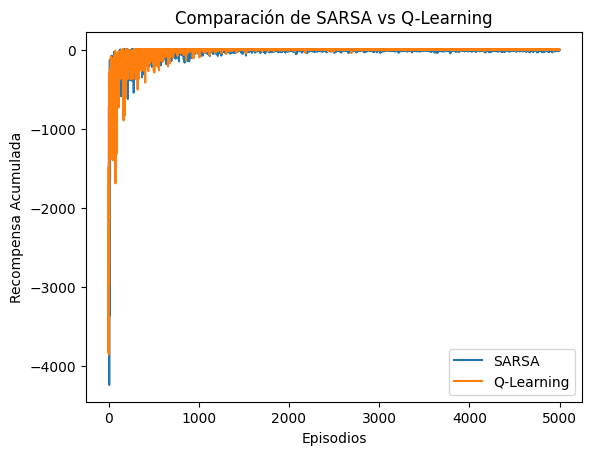

In [5]:
#@title Visualización grafica del rendimiento de cada agente para realizar la comparación de su aprendizaje
plt.plot(rewards_sarsa, label="SARSA")
plt.plot(rewards_qlearning, label="Q-Learning")
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Comparación de SARSA vs Q-Learning")
plt.legend()
plt.show()

# Implementación de Métodos con Aproximación de Función
**SARSA semi-gradiente, Deep Q-Learning.**


In [6]:
#@title Importamos librerias necesarias
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
#@title Creacion de la red neuronal DQN con dos capas ocultas de 128 neuronas y activacion ReLU
# Toma un estado como entrada y predice los valores Q(s, a) para cada acción.
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)
#donde la lr es la tasa de aprendizaje de la red neuronal y epsilon el parametro de exploración
class DQNAgent:
    def __init__(self, env, lr=0.001, gamma=0.99, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            return torch.argmax(self.q_network(state_tensor)).item()

    def train(self, num_episodes=1000):
        episode_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset()[0]
            done = False
            total_reward = 0

            while not done:
                action = self.policy(state)
                next_state, reward, done, _, _ = self.env.step(action)

                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
                action_tensor = torch.tensor(action, dtype=torch.int64).to(self.device)
                reward_tensor = torch.tensor(reward, dtype=torch.float32).to(self.device)

                # Q-Learning update
                target_q = reward_tensor + self.gamma * torch.max(self.q_network(next_state_tensor)).detach()
                predicted_q = self.q_network(state_tensor)[action_tensor]
                loss = self.loss_fn(predicted_q, target_q)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                #Se ajustan los pesos de la red neuronal mediante backpropagation.
                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)

        return episode_rewards


In [8]:
#@title Entrenamiento de DQN en CartPole-v1
# se ha escogido este entorno porque es ideal para redes neuronales, es rápido
#de entrenal y evaluar.
env = gym.make("CartPole-v1")
dqn_agent = DQNAgent(env)

rewards_dqn = dqn_agent.train(num_episodes=1000)

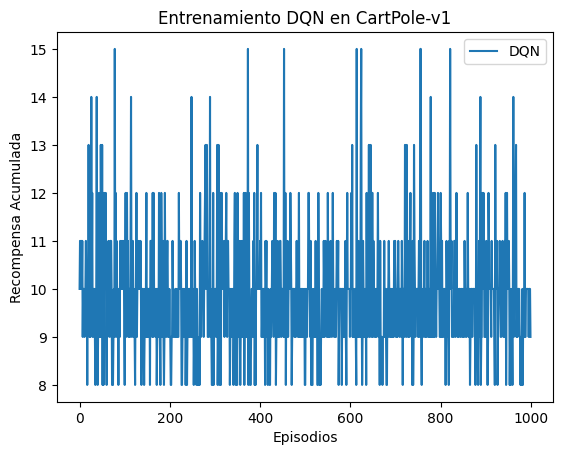

In [9]:
#@title Visualizacion grafica del aprendizaje
plt.plot(rewards_dqn, label="DQN")
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Entrenamiento DQN en CartPole-v1")
plt.legend()
plt.show()

# Comparación final de los algoritmos


*  El algoritmo **Monte Carlo** es de tipo tabular, usa un espacio de estados discreto. Funciona tanto en exploración on como off policy y su tendencia observada es de convergencia más lenta por lo que hace que el aprendizaje sea menos frecuente, a pesar de ser estable. En la gráfica se observa que la recompensa promedio aumenta progresivamente, pero con las variabilidad.
*  El algoritmo **SARSA** también es de tipo tabular y discreto, usa una exploración on-policy. Es un agente seguro pero es menos óptimo. En la tendencía se observa que el aprendizaje es más estable que el Q-Learning. En la gráfica la recompensa promedio aumenta de manera constante, pero más lentamente que en Q-Learning.
* El algoritmo **Q-Learning** es de tipo tabular y discreto, usa una exploración off-policy y a pesar de ser rápido su convergencia es inestable. Su convergencia es más rápida que SARSA y Monte Carlo, ya que siempre elige la acción con la mejor recompensa esperada, sin importar la política actual. En la gráfica, la recompensa promedio se estabiliza más rápido, pero con fluctuencias más marcadas.
* Por último, el algoritmo **DQN en CartPole-v1** es de tipo aproximado y usa un espacio de estados continuo. Usa una exploración off-policy. Este algoritmo requiere de más recursos, tal y como hemos podido verlo, pero ayuda a manejar problemas más complejos. Se puede observar una convergencia extremadamente rápida, en su gráfica podemos observar que la recompensa promedio crece rápidamente hasta alcanzar valores cercanos al máximo. Es la mejor opción cuando los métodos tabulares no pueden manejar la cantidad de estados posibles.




---
## Conclusión
En nuestro código, hemos implementado y entrenado los siguientes algoritmos en el entorno Taxi-v3:

1. Monte Carlo (MC)
2. SARSA (Diferencias Temporales On-Policy)
3. Q-Learning (Diferencias Temporales Off-Policy)

Además, entrenamos DQN (Deep Q-Learning) en el entorno CartPole-v1 debido a su naturaleza de espacio de estado continuo.

El código genera dos gráficas clave:
1. Recompensa promedio por episodio → Evalúa qué tan bien aprende el agente.
2. Longitud del episodio → Muestra cuánto tiempo el agente necesita para alcanzar su objetivo.

En conclusión se podría decir que los algoritmos SARSA y Q-Learning son eficientes en entornos discretos pequeños, pero menos eficiente en problemas deterministas.
En cambio para el algoritmo DQN es necesario para entornos con estados continuos, pero requiere más computación.
Q-Learning converge más rápido que SARSA, pero es menos estable.
Y por último Monte Carlo aprende basándose en episodios completos, lo que puede ser lento